# 1. Preparação do notebook

In [1]:
!pip install hpelm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import hpelm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [3]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [4]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Jumps] Geração de séries temporais.xlsx to [BM Jumps] Geração de séries temporais.xlsx


,bm_jumps_1,bm_jumps_2,bm_jumps_3,bm_jumps_4,bm_jumps_5,bm_jumps_6,bm_jumps_7,bm_jumps_8,bm_jumps_9,bm_jumps_10
0,0.496714,-1.544434,1.562669,-1.068870,-100.752424,0.600506,0.075905,50.045619,-0.249206,-0.940726
1,0.358450,-2.303156,2.040892,-0.755027,-0.575647,0.936496,0.796740,0.494262,1.344256,0.048010
2,1.006138,-2.215918,1.703143,1.142859,-0.846519,1.197469,0.448800,-0.567930,1.263826,-0.575317
3,-135.982789,-1.247409,0.904958,0.761608,-2.947229,-0.223921,0.460505,-1.883760,1.128036,0.474577
4,140.806972,-1.146266,0.172675,0.577442,-3.932071,-48.513417,1.878680,-3.798710,1.336141,0.677151


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [5]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [6]:
# Seleção da série
series = df['bm_jumps_1'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [7]:
X

array([[   0.49671415],
       [   0.35844985],
       [   1.00613839],
       ...,
       [ -28.63059332],
       [ -29.95147167],
       [-167.69202664]])

In [8]:
y

array([   0.35844985,    1.00613839, -135.98278852, ...,  -29.95147167,
       -167.69202664,  -29.17895993])

## 3.2. Normalização

In [9]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [10]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [11]:
# Função para treinar ELM com otimização de hiperparâmetros
def train_elm(X_train, y_train):
    param_grid = {
        'nhid': [5, 10, 20, 50],  # Número de neurônios na camada oculta
        'actfun': ['sigm', 'tanh', 'lin']  # Funções de ativação suportadas
    }

    best_model = None
    best_score = float('inf')

    for nhid in param_grid['nhid']:
        for actfun in param_grid['actfun']:
            model = hpelm.ELM(X_train.shape[1], 1)
            model.add_neurons(nhid, actfun)
            model.train(X_train, y_train)
            predictions = model.predict(X_train).flatten()
            error = np.mean((predictions - y_train) ** 2)  # MSE

            if error < best_score:
                best_score = error
                best_model = model

    return best_model

In [12]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
elm_model = train_elm(X_train, y_train)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.11/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


## 3.3. Avaliação do modelo

In [13]:
# Previsões no conjunto de treino
y_train_pred_scaled = elm_model.predict(X_train).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = elm_model.predict(X_test).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [14]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values).round(2)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values).round(2)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 28.76%
sMAPE Teste: 58.56%


In [15]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 31.74
RMSE Teste: 45.09


In [16]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 10.86
Huber Loss Teste: 22.65


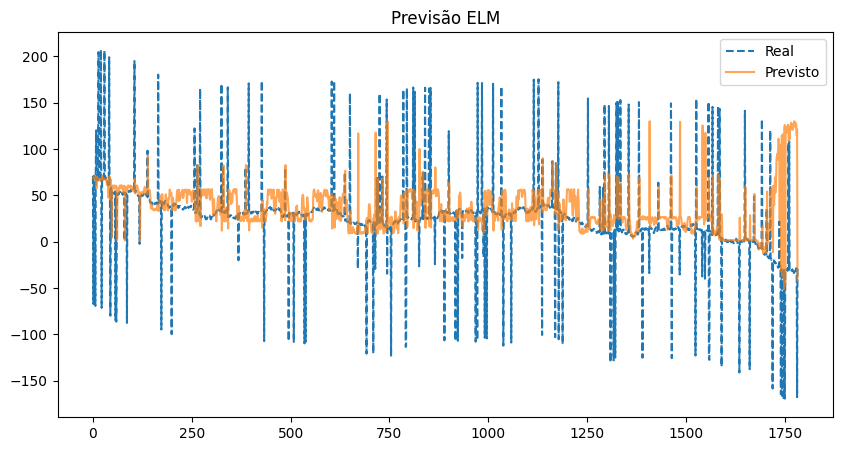

In [17]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão ELM')
plt.show()

# 4. Análise dos erros

In [18]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
2,-135.982789,1.437543,-137.420332
57,-148.766783,-12.763630,-136.003153
122,-198.129656,-10.185022,-187.944633
307,-138.878420,1.717522,-140.595942
347,-138.354009,1.477897,-139.831906
...,...,...,...
1740,-164.580277,95.620155,-260.200432
1743,-166.194379,114.921783,-281.116162
1747,-170.551737,67.897191,-238.448928
1750,-169.276030,125.819410,-295.095440


In [19]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,0.358450,1.588909,-1.230459,False
1,1.006138,1.624740,-0.618601,False
2,-135.982789,1.437543,-137.420332,True
3,140.806972,29.187643,111.619329,False
4,2.060878,57.438017,-55.377139,False


In [20]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 481310.0
Valor-p: 0.033186572503126344
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [21]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 436.3842814498821
Valor-p: 1.739231083448849e-95
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [22]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: 0.02381901390167289
Valor-p: 0.06636537282495543
Não há evidência estatística de que os outliers impactam significativamente os erros.
